In [1]:
from IPython.core.display import HTML
display(HTML('<style>.container { width:95% !important; } </style>'))

%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
from scipy.stats import rv_discrete
import matplotlib.pyplot as plt
from ito_diffusions import PDMP_1d_linear
plt.style.use('dark_background')

## PDMP

$X_t = \alpha_m (t-\tau)$ where
* $\tau$: last jump time,
* $m$: mode,
* $\alpha_m$: slope in mode $m$.

In this example, there are two main modes 'down' ($m=0$) and 'up' ($m=1$), associated to a downward ($\alpha_0<0$) and upward ($\alpha_1>0$) slope respectively.
In addition, there are two limit modes $\perp$ and $\top$ such that $\alpha_{\perp}=\alpha_{\top}=0$.  

Jumps can occur in two different ways:
* Natural jumps: following a Poisson process of constant intensity $Poisson(\lambda)$, in which case there is a $50\%$ probability to change from 'up' to 'down' and conversely;
* Boundary jumps: when $X_t=0$, mode jumps to $\perp$; when $X_t=1$, mode jumps to $\top$.

In [3]:
T = 1
SCHEME_STEPS = int(1e4)

# down, up, absorbing low, absorbing high
modes = (0, 1, 2, 3)

# Poisson intensity (at what rate does the mode naturally jump)
rate = 20

natural_jump_mode_distr = (
    # If in mode 'down', can only go to 'up' or remain in 'down'
    rv_discrete(values=(modes, (0.5, 0.5, 0.0, 0.0))),
    # If in mode 'up', can only go to 'down' or remain in 'up'
    rv_discrete(values=(modes, (0.5, 0.5, 0.0, 0.0))),
    # If in mode 'absorbing low', can only go to 'up' or remain in 'absorbing low'
    rv_discrete(values=(modes, (0.0, 0.5, 0.5, 0.0))),
    # If in mode 'absorbing high', can only go to 'down' or remain in 'absorbing high'
    rv_discrete(values=(modes, (0.5, 0.0, 0.0, 0.5))),
)

jump_params = {
    'jump_intensity_func': lambda t, x, m: rate,
    'jump_mode_func': lambda t, x, m: natural_jump_mode_distr[m],
}

barrier_params = {
    # Absorbing state low, absorbing state high
    'barriers': [0.0, 1.0],
    'jump_mode_func': [
        # Go to mode 'absorbing low' if low barrier is crossed 
        lambda t, x, m: rv_discrete(values=(modes, (0, 0, 1, 0))),
        # Go to mode 'absorbing high' if high barrier is crossed 
        lambda t, x, m: rv_discrete(values=(modes, (0, 0, 0, 1))),
    ]
}

# downward slode, upward slope, flat for the absorbing states
drifts = [-2.5, 2.5, 0.0, 0.0]

In [4]:
X = PDMP_1d_linear(
    x0=0.5, 
    m0=0, 
    T=T, 
    scheme_steps=SCHEME_STEPS, 
    drifts=drifts, 
    jump_params=jump_params,
    barrier_params=barrier_params,
    verbose=True,
)

In [5]:
df = X.simulate()

100%|██████████| 10000/10000 [00:00<00:00, 131159.71it/s]


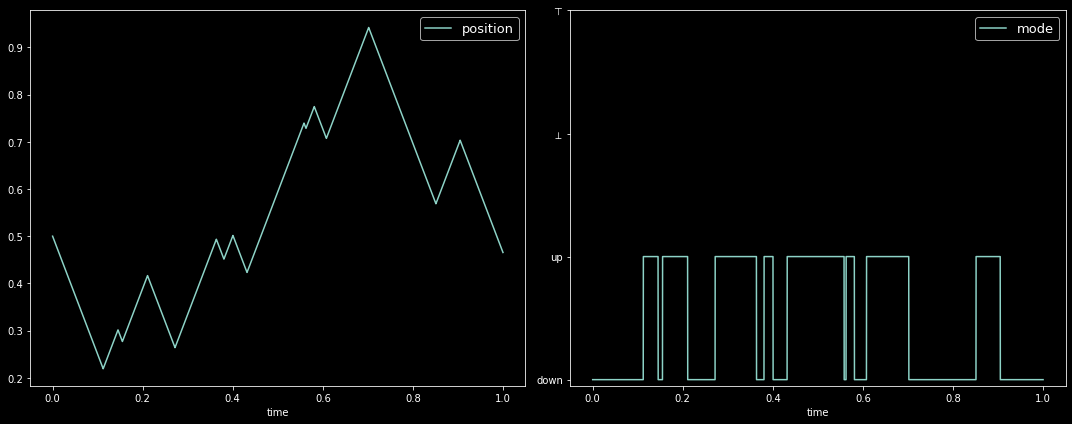

In [6]:
fig, axes = plt.subplots(figsize=(15, 6), nrows=1, ncols=2)

ax = axes[0]
df['position'].plot(kind='line', ax=ax)
ax.legend(loc='upper right', fontsize=13)
ax.set_xlabel('time')

ax = axes[1]
df['mode'].plot(kind='line', ax=ax)
ax.legend(loc='upper right', fontsize=13)
ax.set_xlabel('time')
ax.set_yticks(modes)
ax.set_yticklabels(['down', 'up', r'$\perp$', r'$\top$'])

plt.tight_layout()
plt.show()